# Predictive modelling with Python

*Jure Žabkar, Wed 5th April 2023*

---

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 150 # makes figures bigger

After the initial data set with only 10 samples, let's go rat hunting and collect more data. We store the data in the file and create a new scatter plot for the entire rat collection.
Visualizing data helps us gain more insight: rat size increases with increasing weight, but really fat rats are not the biggest. A possible explanation would be, for example, that excessive weight is due to genetic or health related problem, not the size of the rat.

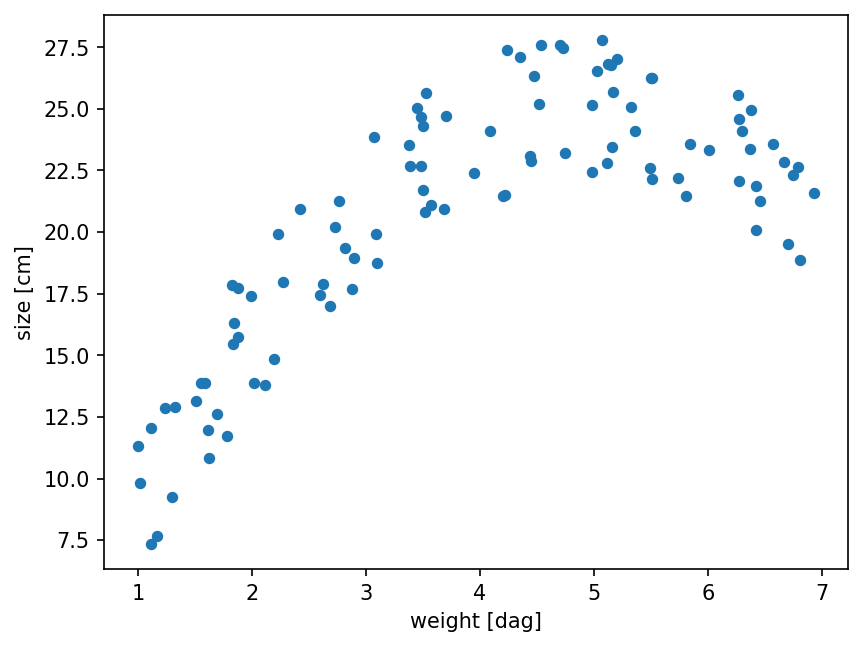

In [2]:
rats = pd.read_csv('datasets/rats-obesity-100examples.csv')

rats.plot.scatter(x='weight', y='size');
plt.xlabel("weight [dag]");
plt.ylabel("size [cm]");

Assuming we had enough rat hunting, this is all the data we could collect.
Our next step will be to put some data aside, so that we could learn/train our model on one subset and test it on another one. It is very important to train and test on different data sets.
There are many possible ways of how we can do this; this time we will take 70% of our data foir training and the remaining 30% for testing.

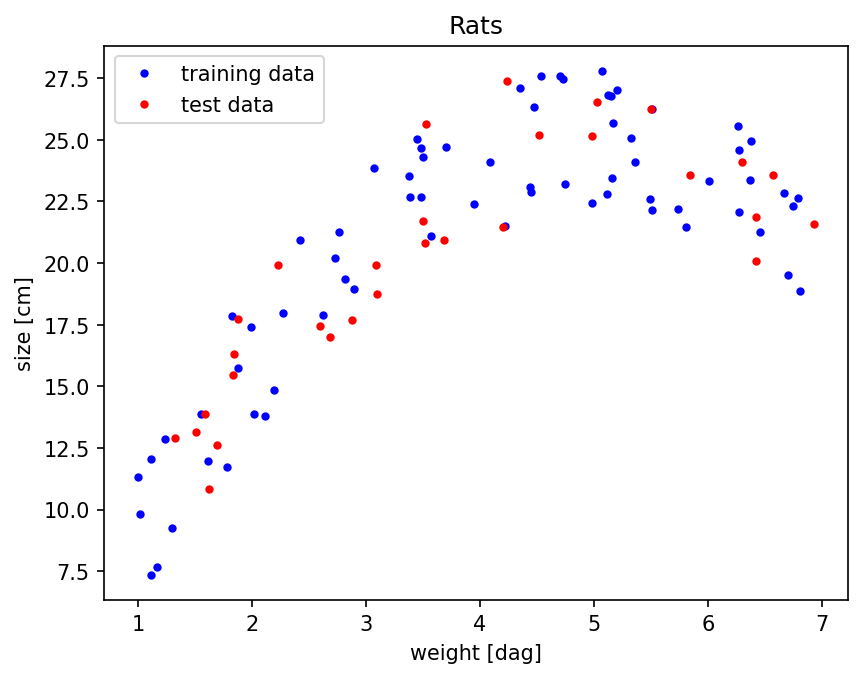

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rats["weight"], rats["size"], test_size=0.3, random_state=42);

plt.plot(X_train, y_train, "b.", label="training data");
plt.plot(X_test, y_test, "r.", label="test data");
plt.xlabel("weight [dag]");
plt.ylabel("size [cm]");
plt.title("Rats");
plt.legend(loc="best");

The correlation between weight and size indicates a strong relation.

In [4]:
df = pd.DataFrame(data={"X_train":X_train, "y_train":y_train})
df.corr()

,X_train,y_train
X_train,1.00000,0.73403
y_train,0.73403,1.00000


Our next goal is to use the **training set** to build the model for prediction of rat's size, given its weight.

Linear regression model:
y = 2.18 x + 12.16


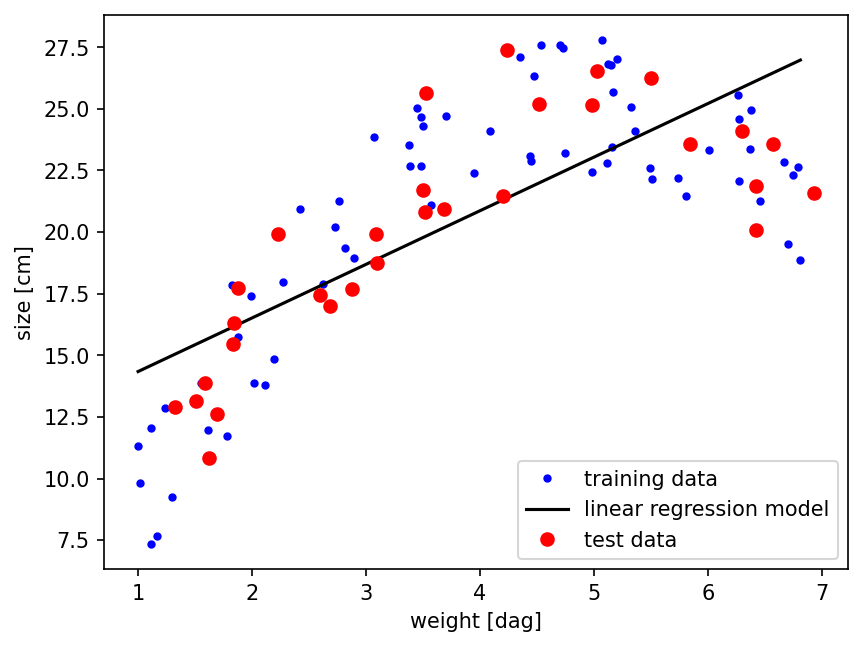

In [5]:
from sklearn.linear_model import LinearRegression

X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1, 1)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print('Linear regression model:\ny = {:.2f} x + {:.2f}'.format(lin_reg.coef_[0], lin_reg.intercept_));
plt.plot(X_train, y_train, "b.", label="training data")
xlr = [min(X_train), max(X_train)]
ylr = lin_reg.predict(xlr)
plt.plot(xlr, ylr, "k-", label="linear regression model")
plt.plot(X_test, y_test, "ro", label="test data")

plt.xlabel("weight [dag]");
plt.ylabel("size [cm]");
#plt.title("Linear regression: High bias, low variance");
plt.legend(loc="best");

The obtained model is obviously too simple to catch the complexity of the underlying data. We say it has a high bias.

**BIAS** = Average prediction of the model - the correct value

Model with high bias doesn't care much about the training data, oversimplifies the model.

A model with high bias leads to high error on training and test data. We can verify this:

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
# R^2: the proportion of the variance in y that is predictable from X_train.
# Explained variance score: 1 is perfect prediction

y_pred = lin_reg.predict(X_test)
print("Model performance on TEST data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred) ))
print('Variance score: {:.2f}\n'.format(r2_score(y_test, y_pred) ))

y_pred_train = lin_reg.predict(X_train)
print("Model performance on TRAIN data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_train, y_pred_train) ))
print('Variance score: {:.2f}'.format(r2_score(y_train, y_pred_train) ))

Model performance on TEST data:
Mean squared error: 8.90
Variance score: 0.56

Model performance on TRAIN data:
Mean squared error: 12.61
Variance score: 0.54


To reduce the bias we should learn a more complex model.

What can we do to enable linear regression to come up with something better? One way is to construct new features: what kind of features would be useful here?

A domain expert is usually the right person to talk to when we start thinking about constructing new features. In our simple 2D example, we can be good domain experts ourselves.

A higher degree polinomial would certainly fit the training data better than the above linear model. It seems that would solve our problem, so let's try it out.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=7)
poly.fit_transform(X_train)

array([[1.00000000e+00, 5.11131700e+00, 2.61255615e+01, 1.33536027e+02,
        6.82544964e+02, 3.48870368e+03, 1.78318704e+04, 9.11443425e+04],
       [1.00000000e+00, 2.76168489e+00, 7.62690343e+00, 2.10631040e+01,
        5.81696560e+01, 1.60646260e+02, 4.43654349e+02, 1.22523351e+03],
       [1.00000000e+00, 6.37531731e+00, 4.06446708e+01, 2.59122673e+02,
        1.65198926e+03, 1.05319557e+04, 6.71445598e+04, 4.28067874e+05],
       [1.00000000e+00, 2.01898252e+00, 4.07629041e+00, 8.22995906e+00,
        1.66161435e+01, 3.35477032e+01, 6.77322262e+01, 1.36750181e+02],
       [1.00000000e+00, 4.47033769e+00, 1.99839190e+01, 8.93348664e+01,
        3.99357020e+02, 1.78526074e+03, 7.98071835e+03, 3.56765060e+04],
       [1.00000000e+00, 1.55403157e+00, 2.41501412e+00, 3.75300818e+00,
        5.83229318e+00, 9.06356772e+00, 1.40850704e+01, 2.18886440e+01],
       [1.00000000e+00, 4.98276787e+00, 2.48279757e+01, 1.23712039e+02,
        6.16428375e+02, 3.07151950e+03, 1.53046687e+04, 7.

By the way, we introduced a very useful feature of sklearn - **the pipeline**. The pipeline helps us in constructing data transformations so that we can carry them out on test data in the exactly the same way as we do on our training data.

In [8]:
poly_pipe = Pipeline([('poly', PolynomialFeatures(degree=19)),
                  ('linear', LinearRegression())])
poly = poly_pipe.fit(X_train, y_train)

Model performance on TEST data:
Mean squared error: 12.48
Variance score: 0.39

Model performance on TRAIN data:
Mean squared error: 3.11
Variance score: 0.89


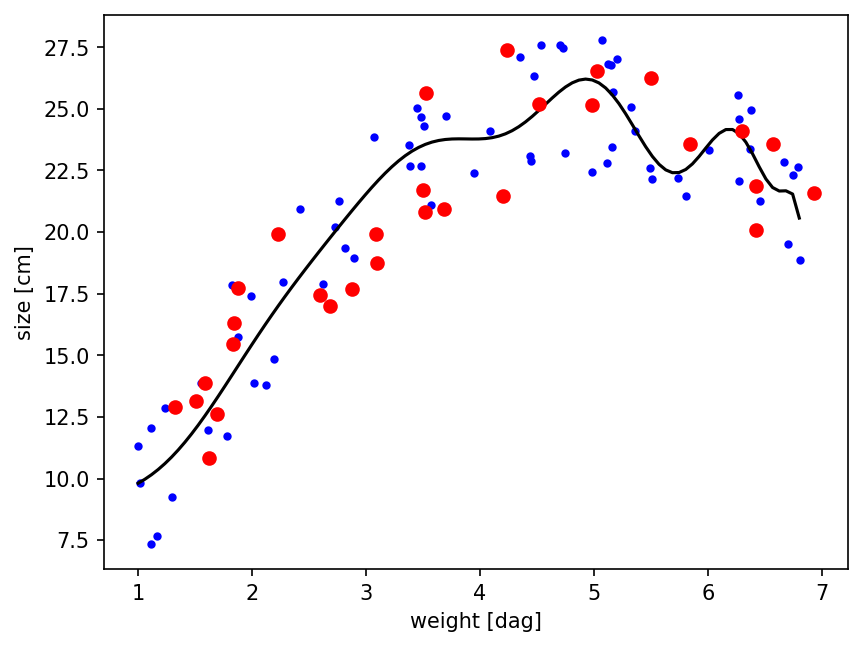

In [9]:
y_pred_poly = poly.predict(X_test);
plt.plot(X_train, y_train, "b.", label="training data");

X_test4 = np.linspace(1, 6.8, 100)
X_test4 = X_test4.reshape(-1, 1)
y_test4 = poly.predict(X_test4)

plt.plot(X_test4, y_test4, "k-", label="13th degree polynomial model")
plt.plot(X_test, y_test, "ro", label="test data")

plt.xlabel("weight [dag]")
plt.ylabel("size [cm]")

print("Model performance on TEST data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred_poly) ))
print('Variance score: {:.2f}\n'.format(r2_score(y_test, y_pred_poly) ))

y_pred_train = poly.predict(X_train)
print("Model performance on TRAIN data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_train, y_pred_train) ))
print('Variance score: {:.2f}'.format(r2_score(y_train, y_pred_train) ))

A high-degree polynomial effectively reduces the bias, but at the same time increases the variance.

**Variance** is the variability of model prediction for a given data point. Model with high variance pays a lot of attention to training data (**overfitting**) but does not generalize well on new data.

Such models perform very well on training data but have high errors on test data.

To get a better model, we will reduce the degree of the polynomial. From observing the above scatterplot, we can assume a quadratic relation (2nd degree polynomial) between the size and the weight...

Model performance on TEST data:
Mean squared error: 3.71
Variance score: 0.82

Model performance on TRAIN data:
Mean squared error: 3.58
Variance score: 0.87


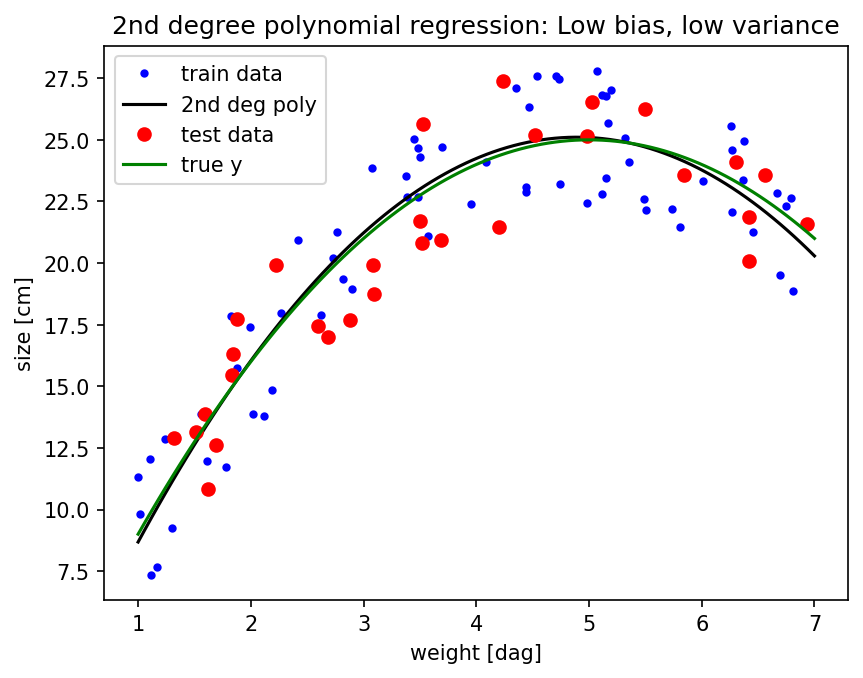

In [10]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression())])
poly_model = poly_model.fit(X_train, y_train)
#print(poly_model.named_steps['linear'].coef_)

Y_pred_poly = poly_model.predict(X_test)
plt.plot(X_train, y_train, "b.", label="train data")

X_test2 = np.linspace(1, 7, 100)
X_test2 = X_test2.reshape(-1, 1)
Y_test2 = poly_model.predict(X_test2)
plt.plot(X_test2, Y_test2, "k-", label="2nd deg poly")
plt.plot(X_test, y_test, "ro", label="test data")

y_true = - ((X_test2-5)**2) +25
plt.plot(X_test2, y_true, "g-", label="true y")

plt.xlabel("weight [dag]")
plt.ylabel("size [cm]")
plt.title("2nd degree polynomial regression: Low bias, low variance")
plt.legend(loc="best")

print("Model performance on TEST data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, Y_pred_poly) ))
print('Variance score: {:.2f}\n'.format(r2_score(y_test, Y_pred_poly) ))

y_pred_train2 = poly_model.predict(X_train)
print("Model performance on TRAIN data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_train, y_pred_train2) ))
print('Variance score: {:.2f}'.format(r2_score(y_train, y_pred_train2) ))

... and get just the right fit :)

However, fitting the model to test data as we did above is not allowed! We did so to illustrate the bias-variance trade-off.

Bellow, we show how to find the best model the right way. To do so, we only use training data and perform so called internal cross-validation. At the end, we test the final model on test data.

In [11]:
print("Fine tuning the models with internal cross-validation")
from sklearn.model_selection import GridSearchCV

Fine tuning the models with internal cross-validation


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
pf = PolynomialFeatures()
lr = LinearRegression()

poly_model = Pipeline([('poly', pf), ('linear', lr)])
parameters = {'poly__degree': range(2,20),
              'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]
             }

grid_search = GridSearchCV(poly_model, parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #print(np.sqrt(-mean_score), params)
    pass

print(grid_search.best_params_)

print("Final testing...")
final_model = grid_search.best_estimator_

{'linear__fit_intercept': False, 'poly__degree': 2}
Final testing...


In [16]:
lr_final = final_model['linear']
cfs = lr_final.coef_
print(cfs)

x1 = np.linspace(1,6.9,100)
y1 = - ((x1-5)**2) +25
y2 = cfs[0] + cfs[1]*x1 + cfs[2]* x1**2
plt.plot(x1, y1, "g-", label="true y");
plt.plot(x1, y2, "b-", label="model");
plt.legend(loc="best");

NameError: name 'final_model' is not defined

In [15]:
y_final = final_model.predict(X_test)
plt.plot(X_train, y_train, "b.", label="train data")
plt.plot(X_test, y_test, "ro", label="test data")

y_true = - ((X_test2-5)**2) +25
plt.plot(X_test2, y_true, "g-", label="true y")

plt.xlabel("weight [dag]")
plt.ylabel("size [cm]")
plt.title("2nd degree polynomial regression: Low bias, low variance")
plt.legend(loc="best")

print("Model performance on TEST data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_final) ))
print('Variance score: {:.2f}\n'.format(r2_score(y_test, y_final) ))

y_final_train = final_model.predict(X_train)
print("Model performance on TRAIN data:")
print("Mean squared error: {:.2f}".format(mean_squared_error(y_train, y_final_train) ))
print('Variance score: {:.2f}'.format(r2_score(y_train, y_final_train) ))

NameError: name 'lr_final' is not defined